# Term Deposit Marketing Analysis


### Reading the data

In [87]:
import pandas as pd
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import seaborn as sns

# read data and create dataframe
df = pd.read_csv('term-deposit-marketing-2020.csv',sep=",")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
age          40000 non-null int64
job          40000 non-null object
marital      40000 non-null object
education    40000 non-null object
default      40000 non-null object
balance      40000 non-null int64
housing      40000 non-null object
loan         40000 non-null object
contact      40000 non-null object
day          40000 non-null int64
month        40000 non-null object
duration     40000 non-null int64
campaign     40000 non-null int64
y            40000 non-null object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


### Checking for null values

In [89]:
print (df.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64


### Data Visualization

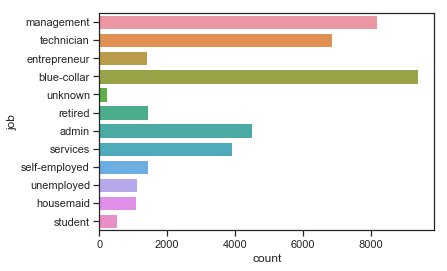

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True)
sns.countplot(y='job', data=df)

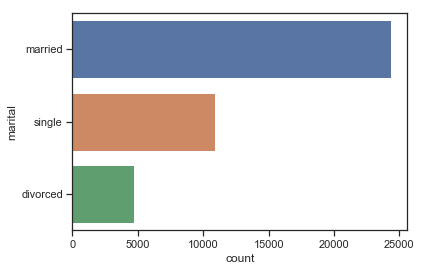

In [91]:
sns.countplot(y='marital', data=df)

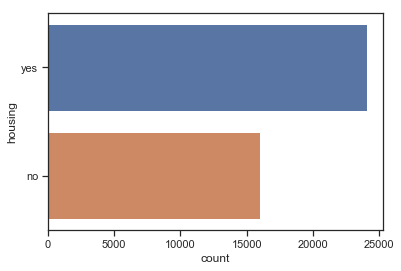

In [92]:
sns.countplot(y='housing', data=df)

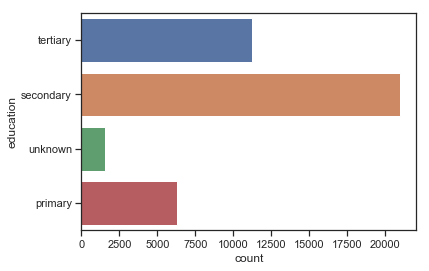

In [93]:
sns.countplot(y='education', data=df)

In [94]:
dep = df['y']
df.drop(labels=['y'], axis=1,inplace=True)
df.insert(0, 'y', dep)
df.head()

,y,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign
0,no,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1
1,no,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1
2,no,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1
3,no,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1
4,no,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1


### Split the data into training and test set

In [95]:
X = df.iloc[:,1:14].values
y = df.iloc[:, 0].values 


In [96]:
# Here we split the data into training and test sets and implement a stratified shuffle split
from sklearn.model_selection import StratifiedShuffleSplit
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in stratified.split(X,y):
    stratified_train = df.loc[train_set]
    stratified_test = df.loc[test_set]

In [97]:
# test and train data
train_data = stratified_train # Make a copy of the stratified training set.
test_data = stratified_test # Make a copy of the stratified testing set.
train_data['y'].value_counts()

no     29683
yes     2317
Name: y, dtype: int64

In [100]:
test_data['y'].value_counts()

no     7421
yes     579
Name: y, dtype: int64

### Preprocessing data

In [101]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
import numpy as np

# function for encoding of categorical data
class CategoricalEncoder(BaseEstimator, TransformerMixin):
   
    

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out


In [102]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [103]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Making pipelines for transforming data
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["age", "balance", "day", "campaign","duration"])),
    ("std_scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["job", "education", "marital", "default", "housing", "loan", "contact", "month"
                                     ])),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

In [104]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train
X_test = preprocess_pipeline.fit_transform(test_data)
X_test

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by StandardScaler.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by StandardScaler.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by StandardScaler.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by StandardScaler.



array([[ 0.24295774, -0.43369484,  0.60885606, ...,  0.        ,
         0.        ,  0.        ],
       [-0.89175625, -0.2572798 ,  0.24803465, ...,  0.        ,
         1.        ,  0.        ],
       [-1.2012237 , -0.21649019, -1.43579858, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.47913298, -0.45171025,  0.48858225, ...,  0.        ,
         0.        ,  0.        ],
       [-0.99491207, -0.4248571 ,  0.48858225, ...,  1.        ,
         0.        ,  0.        ],
       [-0.99491207, -0.43097554, -1.07497718, ...,  0.        ,
         0.        ,  0.        ]])

In [106]:
y_train = train_data['y']
y_test = test_data['y']
y_train.shape

(32000,)

In [107]:
from sklearn.preprocessing import LabelEncoder
#encoding label

encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)


## Building different Models and validating using 5 fold cross validation

In [108]:
import time


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
 # models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=20),
    "Neural Net": MLPClassifier(alpha=1),
    "Naive Bayes": GaussianNB()
}

In [109]:
# Use 5-fold Cross-validation.
from sklearn.model_selection import cross_val_score

# Logistic Regression
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train, y_train, cv=5)
log_reg_mean = log_scores.mean()

# SVC
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=5)
svc_mean = svc_scores.mean()

# KNearestNeighbors
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=5)
knn_mean = knn_scores.mean()

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=5)
tree_mean = tree_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=5)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=18)
rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=5)
rand_mean = rand_scores.mean()

# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=1)
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=5)
neural_mean = neural_scores.mean()

# Naives Bayes
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=5)
nav_mean = neural_scores.mean()

# Create a Dataframe with the results.
d = {'Classifiers': ['Logistic Reg.', 'SVC', 'KNN', 'Dec Tree', 'Grad B CLF', 'Rand FC', 'Neural Classifier', 'Naives Bayes'], 
    'Crossval Mean Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean]}

result_df = pd.DataFrame(data=d)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:

In [110]:
# All our models performances
result_df = result_df.sort_values(by=['Crossval Mean Scores'], ascending=False)
result_df

,Classifiers,Crossval Mean Scores
4,Grad B CLF,0.936625
5,Rand FC,0.934188
0,Logistic Reg.,0.933844
6,Neural Classifier,0.933281
7,Naives Bayes,0.933281
1,SVC,0.931813
2,KNN,0.931656
3,Dec Tree,0.915875


In [114]:
# 5-Fold Cross validate our models with unseen data
from sklearn.model_selection import cross_val_predict

y_test_pred_1 = cross_val_predict(grad_clf, X_test, y_test, cv=5)
y_test_pred_2 = cross_val_predict(log_reg, X_test, y_test, cv=5)
y_test_pred_3 = cross_val_predict(svc_clf, X_test, y_test, cv=5)
y_test_pred_4 = cross_val_predict(knn_clf, X_test, y_test, cv=5)
y_test_pred_5 = cross_val_predict(tree_clf, X_test, y_test, cv=5)
y_test_pred_6 = cross_val_predict(rand_clf, X_test, y_test, cv=5)
y_test_pred_7 = cross_val_predict(neural_clf, X_test, y_test, cv=5)
y_test_pred_8 = cross_val_predict(nav_clf, X_test, y_test, cv=5)


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:

In [115]:
import pandas as pd
import numpy as np
import sklearn
from scipy import stats
import matplotlib.pyplot as plt
import os
import seaborn as sns

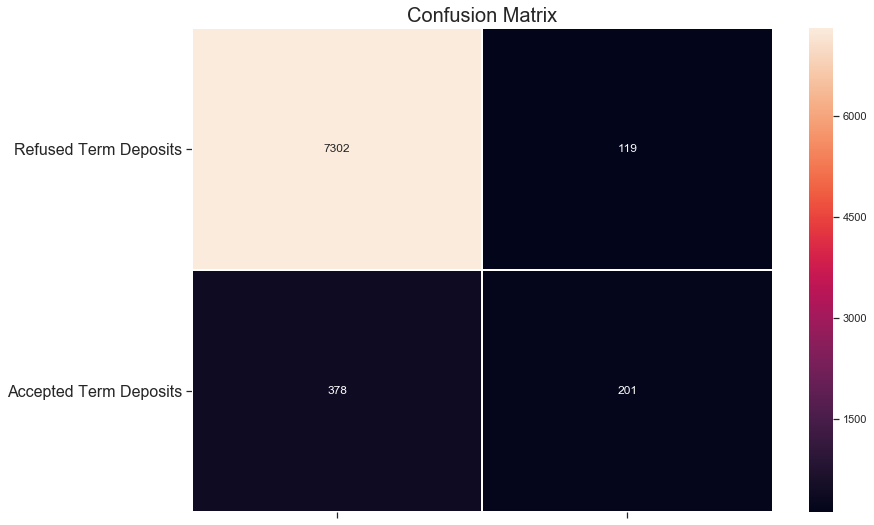

In [116]:
# confusion matrix for gradient boosting classifier model
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_1)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused Term Deposits', 'Accepted Term Deposits'], fontsize=16, rotation=360)
plt.show()

In [117]:
# Let's find the scores for precision,recall,f1 and accuracy.
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print("Gradient Boosting Classifier -------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_1))
print('Precision Score: ', precision_score(y_test, y_test_pred_1))
print('Recall Score: ', recall_score(y_test, y_test_pred_1))
print('F1 Score: ', f1_score(y_test, y_test_pred_1))
print("Logistic Regression -------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_2))
print('Precision Score: ', precision_score(y_test, y_test_pred_2))
print('Recall Score: ', recall_score(y_test, y_test_pred_2))
print('F1 Score: ', f1_score(y_test, y_test_pred_2))
print("SVM -------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_3))
print('Precision Score: ', precision_score(y_test, y_test_pred_3))
print('Recall Score: ', recall_score(y_test, y_test_pred_3))
print('F1 Score: ', f1_score(y_test, y_test_pred_3))
print("KNeighbors Classifier-------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_4))
print('Precision Score: ', precision_score(y_test, y_test_pred_4))
print('Recall Score: ', recall_score(y_test, y_test_pred_4))
print('F1 Score: ', f1_score(y_test, y_test_pred_4))
print("Decision Trees Classifier-------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_5))
print('Precision Score: ', precision_score(y_test, y_test_pred_5))
print('Recall Score: ', recall_score(y_test, y_test_pred_5))
print('F1 Score: ', f1_score(y_test, y_test_pred_5))
print("Random Forest Classifier-------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_6))
print('Precision Score: ', precision_score(y_test, y_test_pred_6))
print('Recall Score: ', recall_score(y_test, y_test_pred_6))
print('F1 Score: ', f1_score(y_test, y_test_pred_6))
print("MLP Classifier-------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_7))
print('Precision Score: ', precision_score(y_test, y_test_pred_7))
print('Recall Score: ', recall_score(y_test, y_test_pred_7))
print('F1 Score: ', f1_score(y_test, y_test_pred_7))
print("GaussianNB-------------------------------------------------")
print('Accuracy Score: ', accuracy_score(y_test, y_test_pred_8))
print('Precision Score: ', precision_score(y_test, y_test_pred_8))
print('Recall Score: ', recall_score(y_test, y_test_pred_8))
print('F1 Score: ', f1_score(y_test, y_test_pred_8))

Gradient Boosting Classifier -------------------------------------------------
Accuracy Score:  0.937875
Precision Score:  0.628125
Recall Score:  0.3471502590673575
F1 Score:  0.4471635150166852
Logistic Regression -------------------------------------------------
Accuracy Score:  0.938
Precision Score:  0.652014652014652
Recall Score:  0.307426597582038
F1 Score:  0.4178403755868545
SVM -------------------------------------------------
Accuracy Score:  0.932875
Precision Score:  0.6615384615384615
Recall Score:  0.14853195164075994
F1 Score:  0.24259520451339917
KNeighbors Classifier-------------------------------------------------
Accuracy Score:  0.934625
Precision Score:  0.6359223300970874
Recall Score:  0.22625215889464595
F1 Score:  0.3337579617834395
Decision Trees Classifier-------------------------------------------------
Accuracy Score:  0.91375
Precision Score:  0.40176991150442476
Recall Score:  0.3920552677029361
F1 Score:  0.3968531468531468
Random Forest Classifier----

## Question 1

Goal(s):

* Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

Success Metric(s):

* Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.


### Answer:

* Accuracy scores and cross-validation mean scores are high rate but recall and precision and f1-score are low rates. This is because data is imbalanced. We need to take different approaches to balance data. Since Logistic Regression and Gradient Boosting Classifier give the highest accuracy and f1 scores, we chose this model and we will continue.
 

* Cross Validation Avarage Result*
* 5-Fold Cross Validation Avarage Score of Logistic Regression:0.938
* 5-Fold Cross Validation Avarage Score of Decision Tree:0.9378



1) Logistic Regression
  * Accuracy Score:  0.938
  * Precision Score:  0.652014652014652
  * Recall Score:  0.307426597582038
  * F1 Score:  0.4178403755868545


2) Gradient Boost Classifier
  * Accuracy Score:  0.937875
  * Precision Score:  0.628125
  * Recall Score:  0.3471502590673575
  * F1 Score:  0.4471635150166852


In [118]:
m = (df['y'] == 'yes')
df1=df[m]
n = (df['y'] == 'no')
df2=df[n]

In [119]:
df1.head()

,y,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign
83,yes,59,admin,married,secondary,no,2343,yes,no,unknown,5,may,1042,1
86,yes,56,admin,married,secondary,no,45,no,no,unknown,5,may,1467,1
87,yes,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1
129,yes,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1
168,yes,54,admin,married,tertiary,no,184,no,no,unknown,5,may,673,2


## Question 2

We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.


### Answer:

### The segment(s) of customers

In [120]:
# Age

df1.groupby(['age']).size().sort_values(ascending=False).head(15)

age
32    149
30    134
31    132
33    127
35    127
34    117
36    114
29     98
39     97
37     97
28     88
38     87
41     83
40     82
26     81
dtype: int64

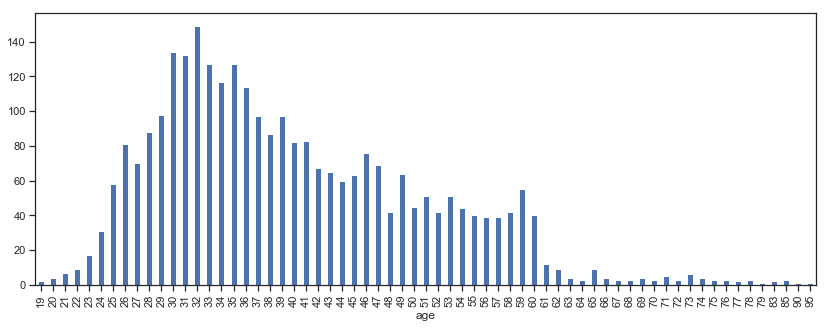

In [121]:
plt.clf()
df1.groupby('age').size().plot(kind='bar',figsize=(14,5))
plt.show()

*  When we look at the data group by age, we see graphs, mod value is 32 age. we should focus between 32-5, 32+5 ages. Because customers is in this age of range do the most buying.

In [122]:
# month

df1.groupby(['month']).size().sort_values(ascending=False).head(20)

month
may    791
apr    451
jul    384
jun    294
aug    288
feb    255
nov    220
mar    125
oct     49
jan     38
dec      1
dtype: int64

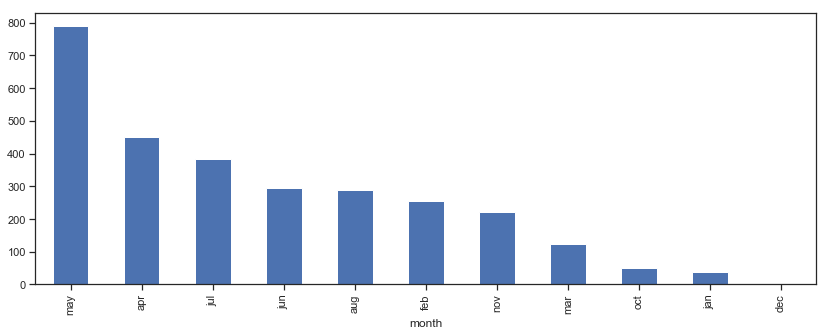

In [123]:
plt.clf()
df1.groupby('month').size().sort_values(ascending=False).plot(kind='bar',figsize=(14,5))
plt.show()

* When we look at the data group by month, we see graphs, mod value is may month. we should focus on May, April, July, June. Because customers are in these months do the most buying.

In [124]:
#job

df1.groupby(['job']).size().sort_values(ascending=False).head(20)

job
management       676
blue-collar      535
technician       497
admin            351
services         238
retired          151
self-employed    112
unemployed        96
entrepreneur      88
student           82
housemaid         53
unknown           17
dtype: int64

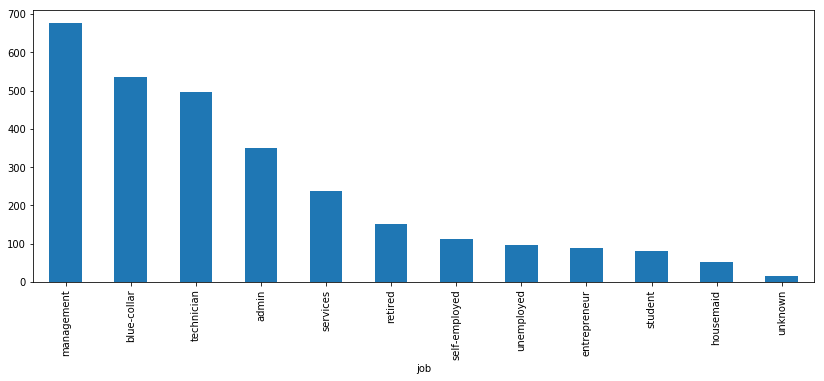

In [110]:
plt.clf()
df1.groupby('job').size().sort_values(ascending=False).plot(kind='bar',figsize=(14,5))
plt.show()

* When we look at the data group by job, we see graphs, mod value is management job. we should focus on management,blue-collar,technican.Customers who have these jobs, they do the most buying .


In [125]:
#housing

df1.groupby(['housing']).size().sort_values(ascending=False).head(20)

housing
yes    1464
no     1432
dtype: int64


* When we look at the data group by housing. Customers who have a housing loan, they do the most buying. At the same time,The number of purchases of those who have housing loan and those who do not have a home loan is almost the same, it may not make sense to comment on a housing loan.


In [126]:
df1.groupby(['day']).size().sort_values(ascending=False).head(15)

day
30    224
18    165
20    153
21    139
15    123
4     117
13    117
14    115
17    115
5     113
6     110
12    104
2     104
8     102
16     96
dtype: int64

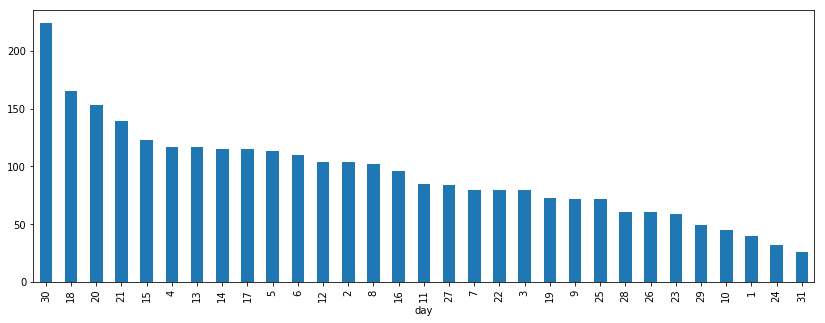

In [112]:
df1.groupby('day').size().sort_values(ascending=False).plot(kind='bar',figsize=(14,5))

*  When we look at the data group by day, we see graphs, mod value is the 30th of the month. we should focus on day  30th,18th, 20th, 21th. Because customers are in these days do the most buying.

In [127]:
df1.groupby(['loan']).size().sort_values(ascending=False)

loan
no     2516
yes     380
dtype: int64

* When we look at the data group by loan. Customers who have loan, they do the most buying. we should focus on customers who have loan.Customers who has loan, they do the most buying .

In [128]:
df1.groupby(['duration']).size().sort_values(ascending=False)

duration
158     11
709      8
165      8
229      7
384      7
261      7
716      7
712      7
482      7
670      7
227      7
574      7
618      7
475      7
412      7
536      7
528      7
154      7
686      7
1063     7
676      7
638      6
268      6
645      6
504      6
615      6
808      6
266      6
442      6
253      6
        ..
1013     1
1011     1
1010     1
1009     1
1006     1
991      1
983      1
1053     1
1055     1
1056     1
1093     1
1111     1
1110     1
1107     1
1105     1
1103     1
1098     1
1096     1
1095     1
1090     1
1058     1
1088     1
1087     1
1086     1
1085     1
1082     1
1075     1
1070     1
1061     1
8        1
Length: 1247, dtype: int64

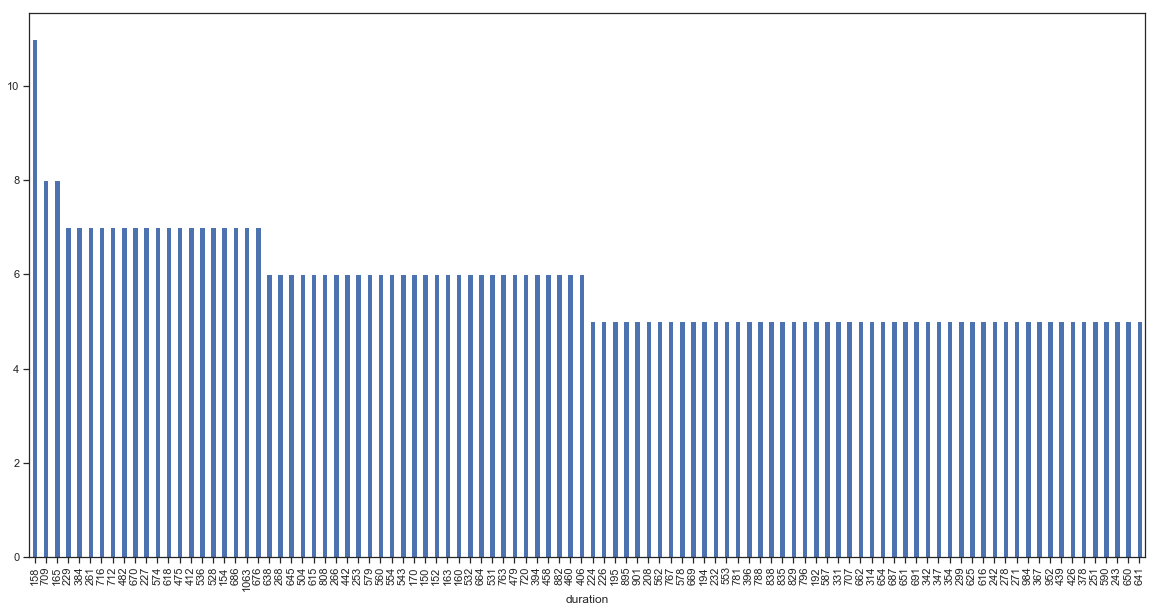

In [129]:
df1.groupby(['duration']).size().sort_values(ascending=False).head(100).plot(kind='bar',figsize=(20,10))

In [130]:
# Duration
print(df1['duration'].mean())

682.9585635359116


In [131]:
print(df1['duration'].median())

629.0


In [132]:
print(df1['duration'].mode())

0    158
dtype: int64


* When we look at the data group by duration, mod value is 158 seconds,mean is 682 second, median is 629 second.we should focus to keep duration time smaller from mean value(682) to improve customers buying .

In [133]:
# SelectKBest method

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
df = pd.read_csv('term-deposit-marketing-2020.csv',sep=",")
X = df.iloc[:, :-1].values   #independent columns
y = df.iloc[:, -1].values     #target column i.e price range
labelencoder_ = LabelEncoder()
for i in range(13):
  X[:,i] = labelencoder_.fit_transform(X[:,i])
y = labelencoder_.fit_transform(y)
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
#featureScores=featureScores.sort_values(by='weightz')
print(featureScores.nlargest(10,'Score'))  #print 10 best features

        Specs         Score
11   duration  2.045278e+06
5     balance  1.066761e+05
8     contact  3.921261e+02
12   campaign  3.607691e+02
10      month  1.308415e+02
0         age  7.180656e+01
6     housing  4.714734e+01
7        loan  3.184029e+01
1         job  3.022289e+01
3   education  2.590045e+01


## Question 3
What makes the customers buy? Tell us which feature we should be focusing more on.

### Answer:
The most effective feature is the duration. We need to focus on duration. If we find the best duration for buying, we can try to keep the duration optimal time to improve customers buying.